https://distill.pub/2018/differentiable-parameterizations/#section-xy2rgb

In [2]:
from __future__ import print_function

import sys
sys.path.append('C:\Program Files\Python37\lib\site-packages')


import io
import string
import numpy as np
import PIL
import base64
from glob import glob

import matplotlib.pylab as pl

import tensorflow as tf
from tensorflow.contrib import slim

from IPython.display import clear_output, Image, display, HTML


In [3]:
tf.version.VERSION

'1.14.0'

In [4]:
from lucid.modelzoo import vision_models
from lucid.misc.io import show, save, load
from lucid.optvis import objectives
from lucid.optvis import render
from lucid.misc.tfutil import create_session

In [5]:
model = vision_models.InceptionV1()
model.load_graphdef()

W0719 09:11:40.183266 14344 deprecation_wrapper.py:119] From C:\Users\c-cbk4\AppData\Roaming\Python\Python37\site-packages\lucid\misc\io\reading.py:126: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0719 09:11:40.186273 14344 deprecation_wrapper.py:119] From C:\Users\c-cbk4\AppData\Roaming\Python\Python37\site-packages\lucid\misc\io\loading.py:72: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



In [6]:
def composite_activation(x):
    x = tf.atan(x)
  # Coefficients computed by:
  #   def rms(x):
  #     return np.sqrt((x*x).mean())
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   print(rms(a), rms(a*a))
    return tf.concat([x/0.67, (x*x)/0.6], -1)


def composite_activation_unbiased(x):
    x = tf.atan(x)
  # Coefficients computed by:
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   aa = a*a
  #   print(a.std(), aa.mean(), aa.std())
    return tf.concat([x/0.67, (x*x-0.45)/0.396], -1)


def relu_normalized(x):
    x = tf.nn.relu(x)
  # Coefficients computed by:
  #   a = np.random.normal(0.0, 1.0, 10**6)
  #   a = np.maximum(a, 0.0)
  #   print(a.mean(), a.std())
    return (x-0.40)/0.58


def image_cppn(
    size,
    num_output_channels=3,
    num_hidden_channels=24,
    num_layers=8,
    activation_fn=composite_activation,
    normalize=False):
    r = 3.0**0.5  # std(coord_range) == 1.0
    coord_range = tf.linspace(-r, r, size)
    y, x = tf.meshgrid(coord_range, coord_range, indexing='ij')
    net = tf.expand_dims(tf.stack([x, y], -1), 0)  # add batch dimension

    with slim.arg_scope([slim.conv2d], kernel_size=1, activation_fn=None):
        for i in range(num_layers):
            in_n = int(net.shape[-1])
            net = slim.conv2d(
                net, num_hidden_channels,
                # this is untruncated version of tf.variance_scaling_initializer
                weights_initializer=tf.random_normal_initializer(0.0, np.sqrt(1.0/in_n)),
            )
            if normalize:
                net = slim.instance_norm(net)
            net = activation_fn(net)
      
        rgb = slim.conv2d(net, num_output_channels, activation_fn=tf.nn.sigmoid,
                      weights_initializer=tf.zeros_initializer())
    return rgb

W0718 12:36:18.472324  8840 deprecation_wrapper.py:119] From C:\Users\c-cbk4\AppData\Roaming\Python\Python37\site-packages\lucid\optvis\render.py:88: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0718 12:36:18.743722  8840 deprecation_wrapper.py:119] From C:\Users\c-cbk4\AppData\Roaming\Python\Python37\site-packages\lucid\optvis\render.py:223: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 12:36:18.743722  8840 deprecation_wrapper.py:119] From C:\Users\c-cbk4\AppData\Roaming\Python\Python37\site-packages\lucid\optvis\render.py:244: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0718 12:36:18.743722  8840 deprecation_wrapper.py:119] From C:\Users\c-cbk4\AppData\Roaming\Python\Python37\site-packages\lucid\optvis\render.py:169: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.

W0718


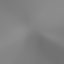
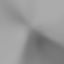
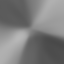
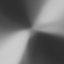
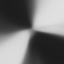
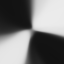
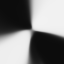
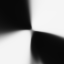
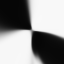
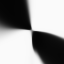

In [5]:
cppn_f = lambda: image_cppn(64, 3, 24, 8)
optimizer = tf.train.AdamOptimizer(0.01)

def xor_objective(T):
    a = T('input')[0]
    return -(tf.square(a[0, 0])      + tf.square(a[-1, -1]) + 
           tf.square(1.0-a[-1, 0]) + tf.square(1.0-a[0, -1]))

vis = render.render_vis(model, xor_objective, param_f=cppn_f, optimizer=optimizer, transforms=[], thresholds=range(10), verbose=False)
show(vis)

0:


W0718 10:47:37.340401  3784 deprecation.py:323] From C:\Users\c-cbk4\AppData\Roaming\Python\Python37\site-packages\lucid\misc\redirected_relu_grad.py:95: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



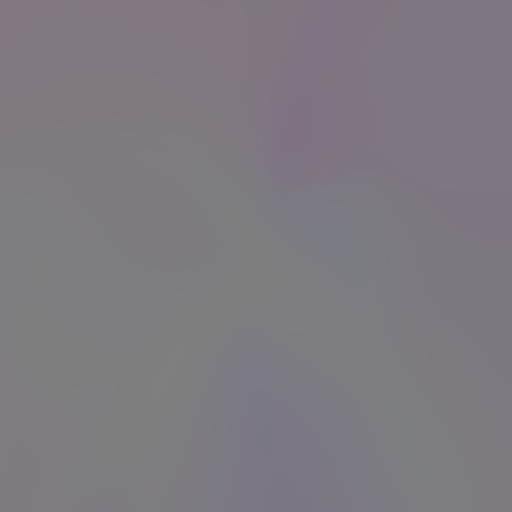
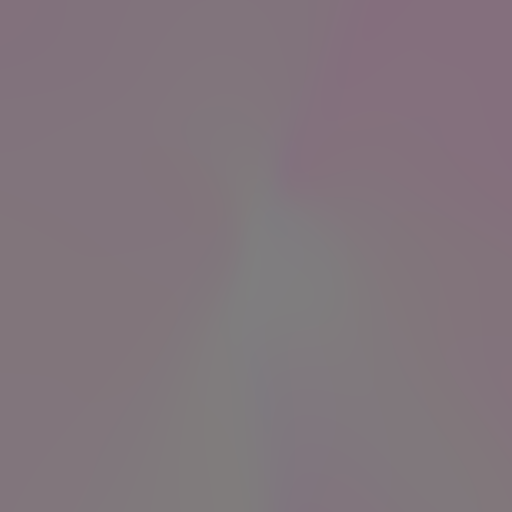
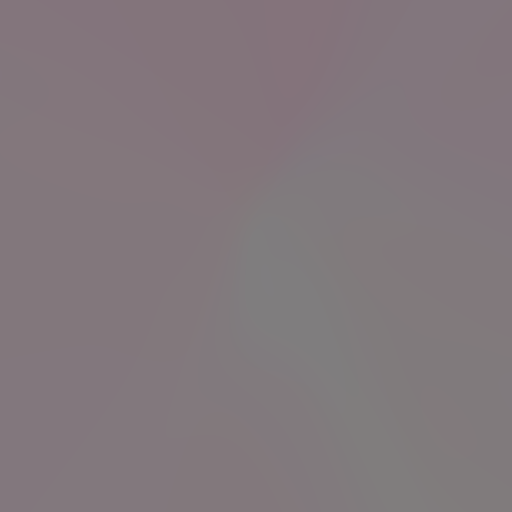
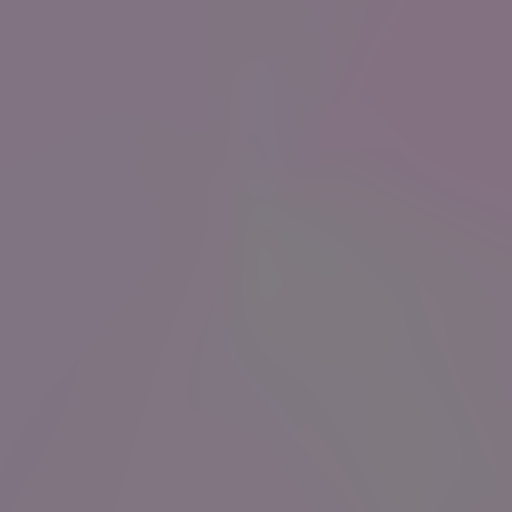
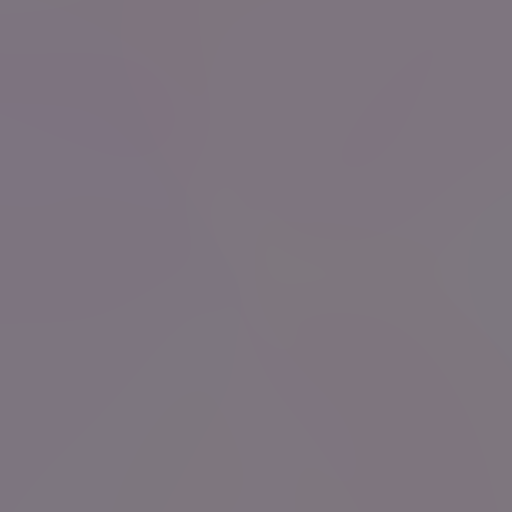
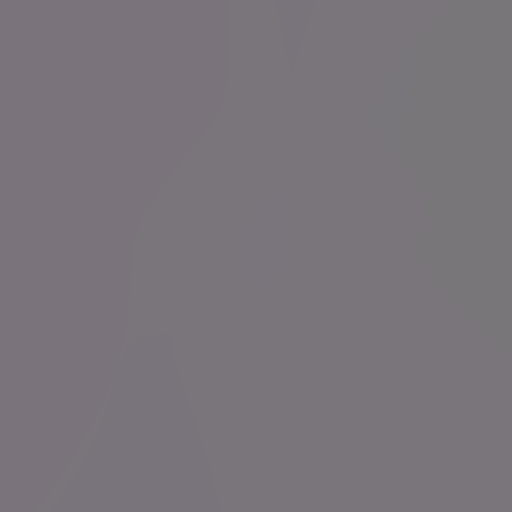
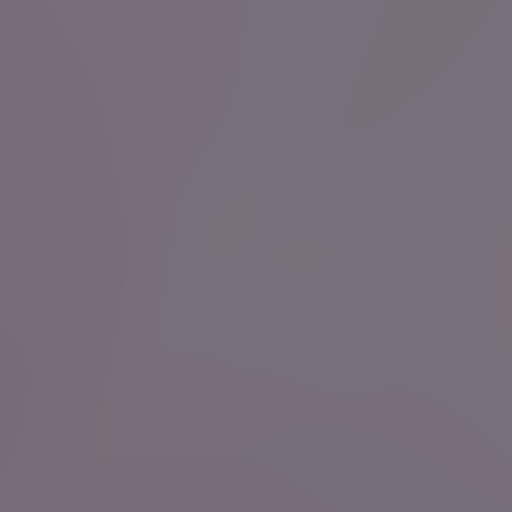
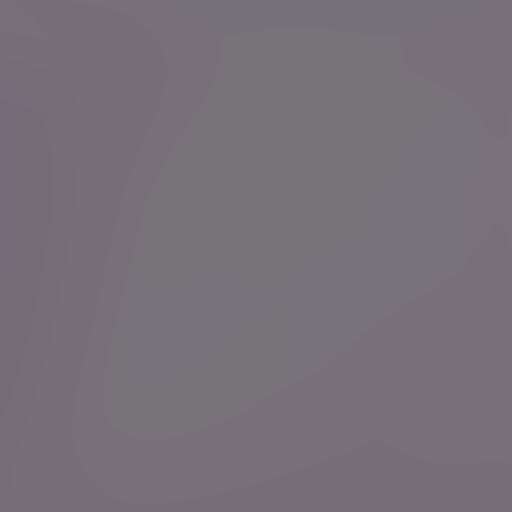
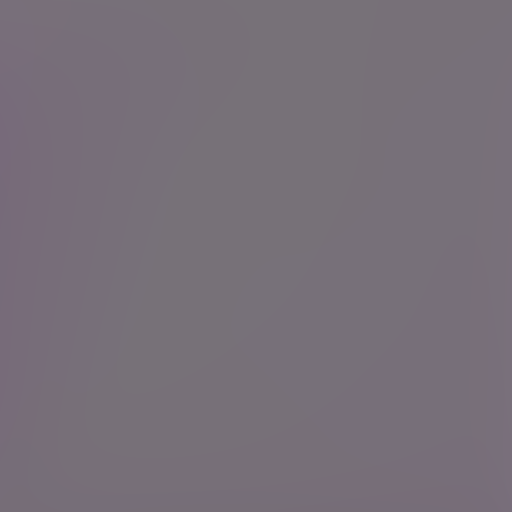

1:


W0718 10:52:42.896596  3784 render.py:111] Interrupted optimization at step 44.



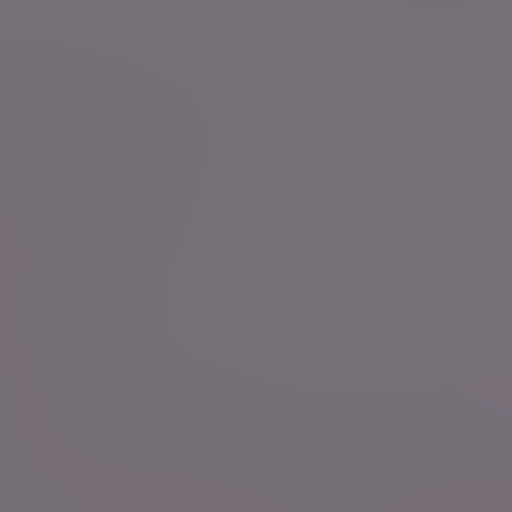


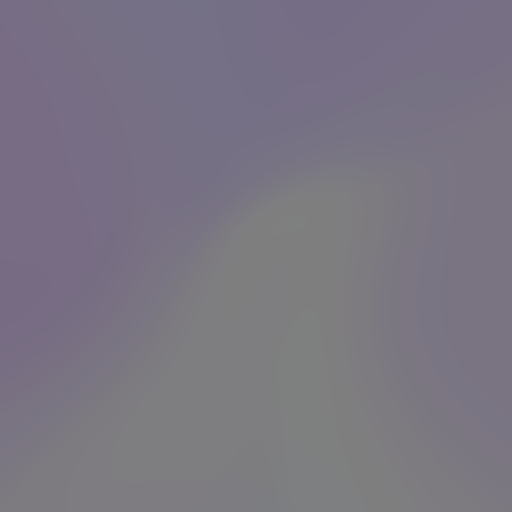
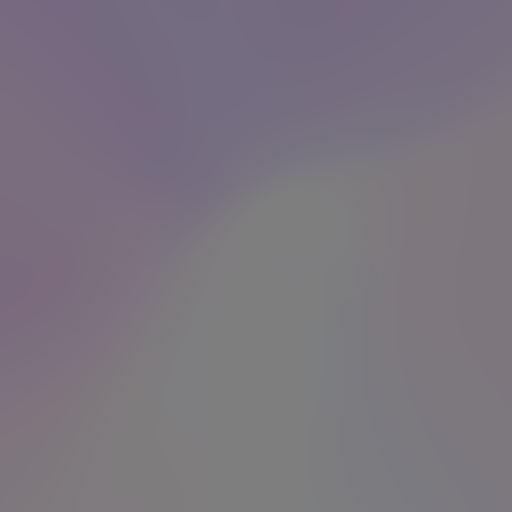
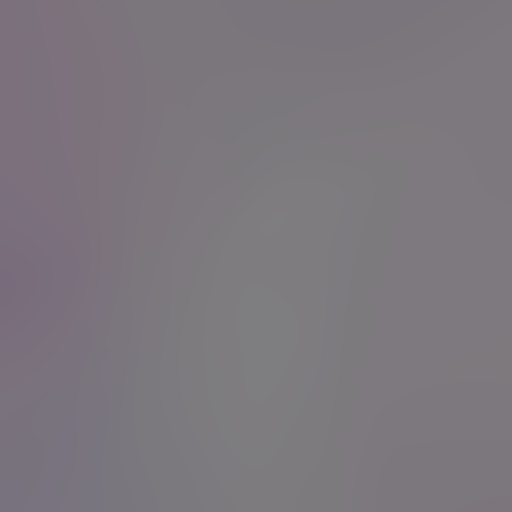
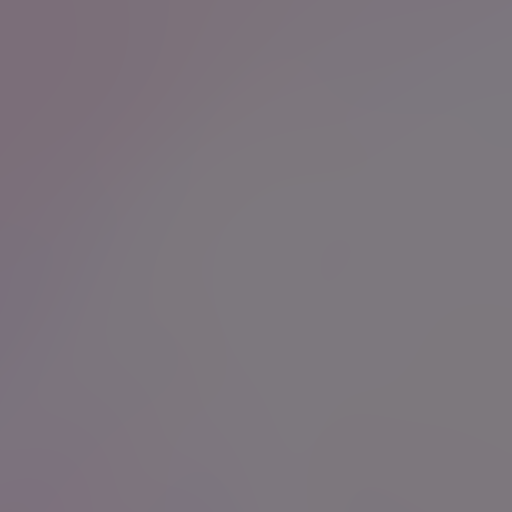
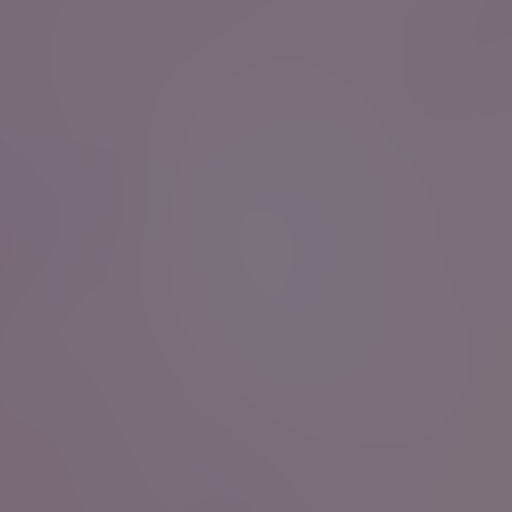
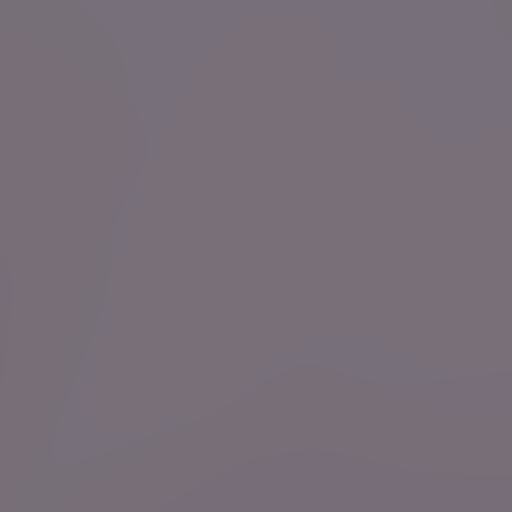

2:


W0718 10:52:47.182040  3784 render.py:111] Interrupted optimization at step 2.



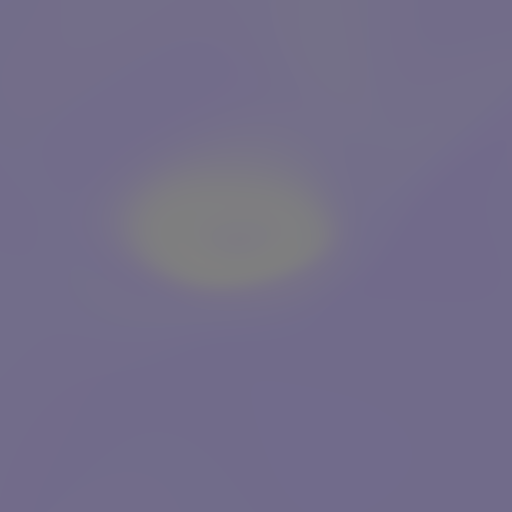

3:


KeyboardInterrupt: 

In [9]:

def render_feature(
    cppn_f = lambda: image_cppn(224),
    optimizer = tf.train.AdamOptimizer(0.01),
    objective = objectives.channel("softmax0_pre_activation/matmul", 316)):
    vis = render.render_vis(model, objective, param_f=cppn_f, optimizer=optimizer, transforms=[], thresholds=[2**i for i in range(9)], verbose=False)
    show(vis)
start_ind = 0
for j in range(5):
    print(str(j+start_ind)+ ':')
    render_feature(cppn_f = lambda: image_cppn(512, 3, 10, 8), objective = objectives.channel("mixed4a_pool_reduce_pre_relu", 49))
    

In [14]:
rubberDuckyTown = objectives.channel("mixed4a_pool_reduce_pre_relu", 3)
astroStuff = objectives.channel("head0_bottleneck_pre_relu", 0)
stainedGlass = objectives.channel("mixed4a_pool_reduce_pre_relu", 52)
vortex = objectives.channel("mixed4c_pool_reduce_pre_relu", 1)
glassCars = objectives.channel("mixed4b_3x3_pre_relu", 77)
flowers = objectives.channel("mixed4b_pool_reduce_pre_relu", 16)
genderNebula = objectives.channel("mixed4e_3x3_pre_relu", 18)
#activation Functions
compAct = composite_activation
compActUnbias = composite_activation_unbiased
relu = relu_normalized
abso = tf.abs

In [10]:
def render_feature(
    cppn_f = lambda: image_cppn(224),
    optimizer = tf.train.AdamOptimizer(0.01),
    objective = objectives.channel("mixed4a_pool_reduce_pre_relu", 50)):
    vis = render.render_vis(model, objective, param_f=cppn_f, optimizer=optimizer, transforms=[], thresholds=[2**i for i in range(8)], verbose=False)
    show(vis)

0:



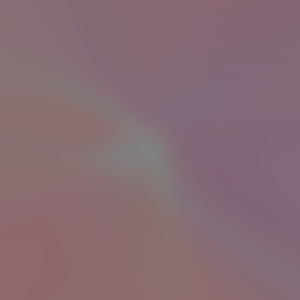
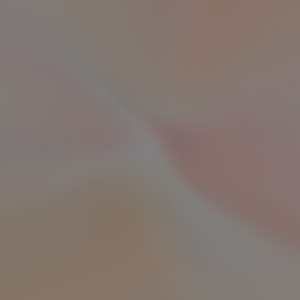
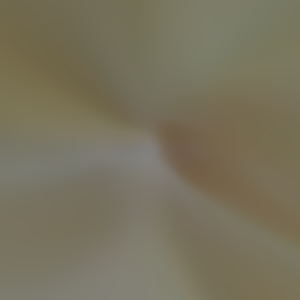
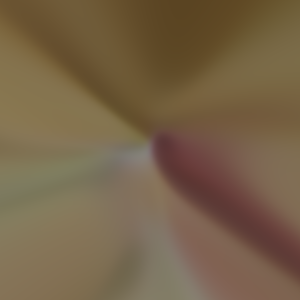
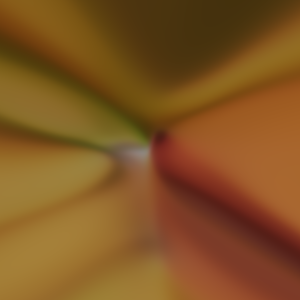
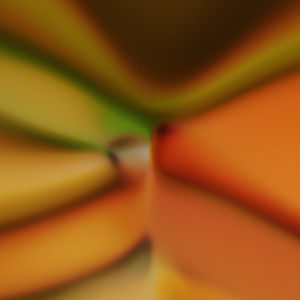
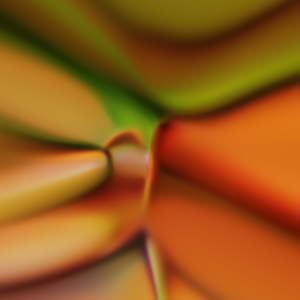
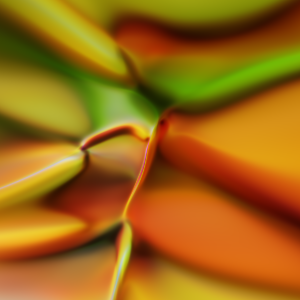

1:



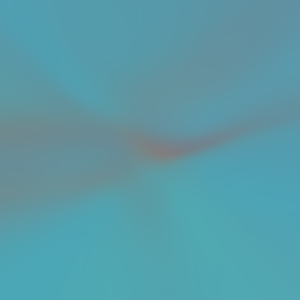
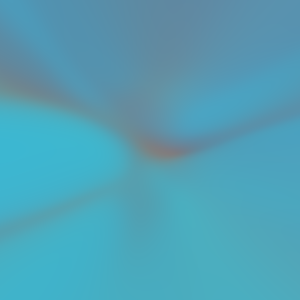
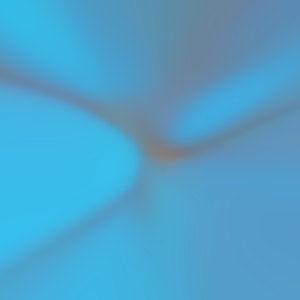
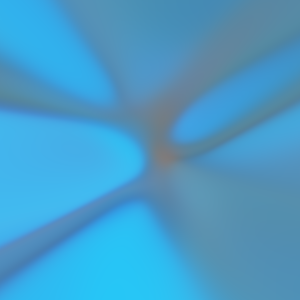
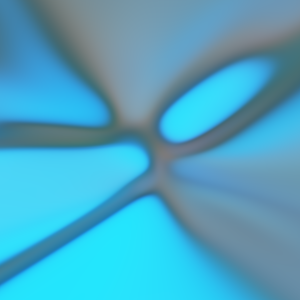
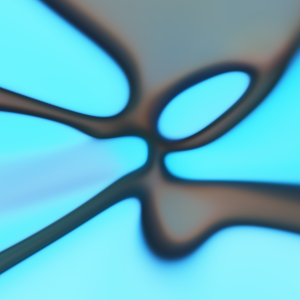
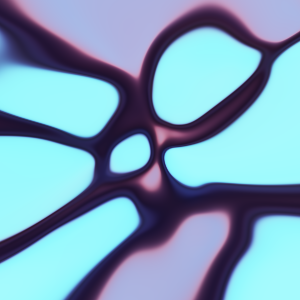
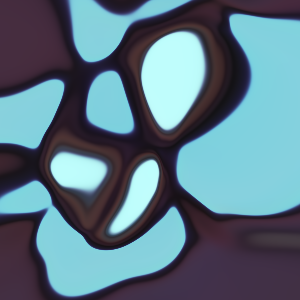

2:



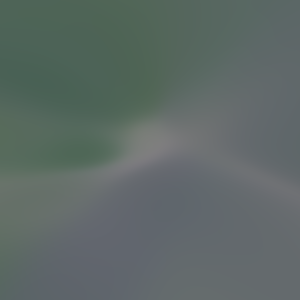
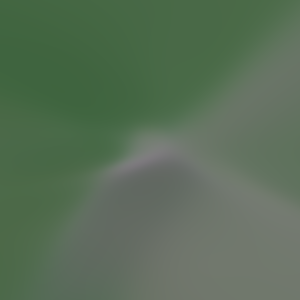
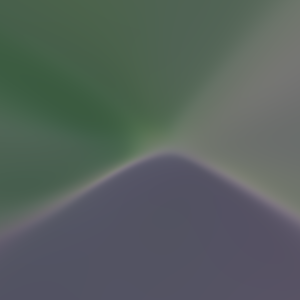
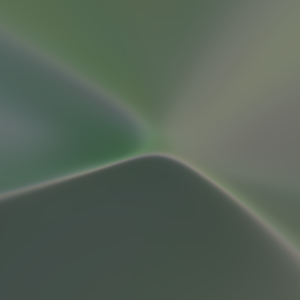
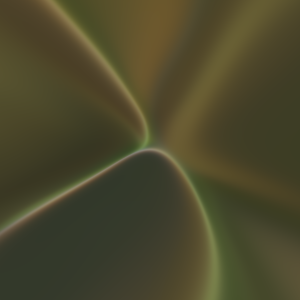
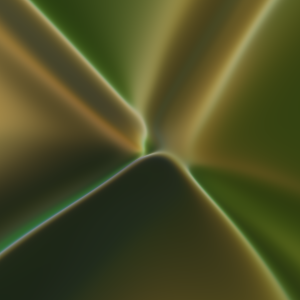
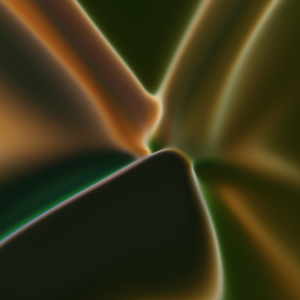
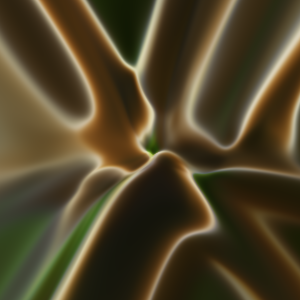

3:



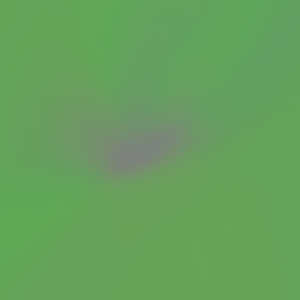
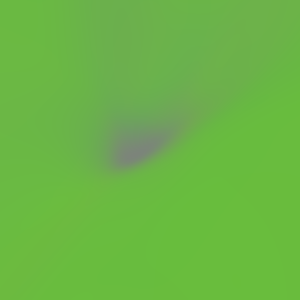
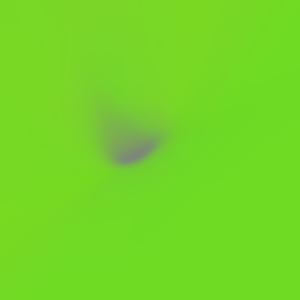
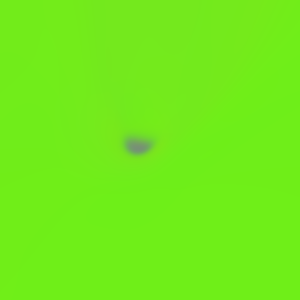
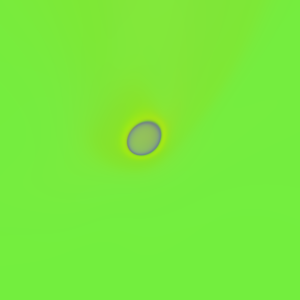
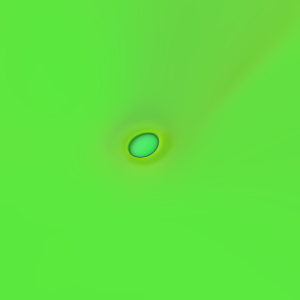
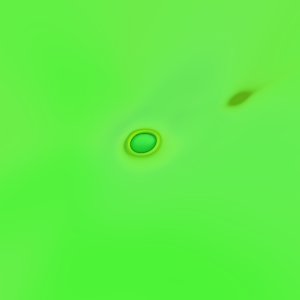
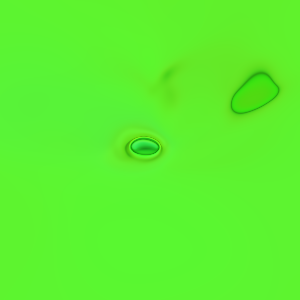

4:



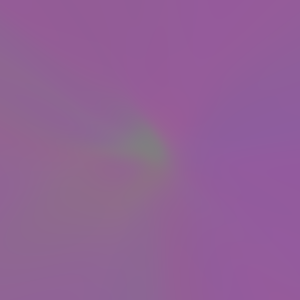
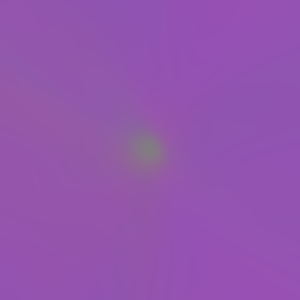
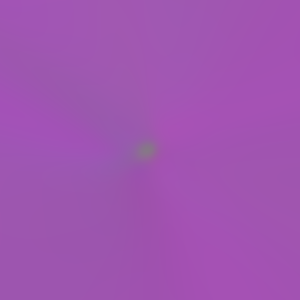
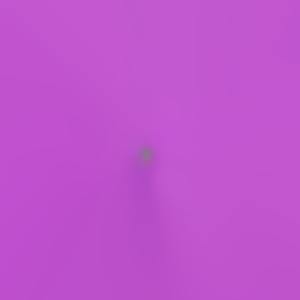
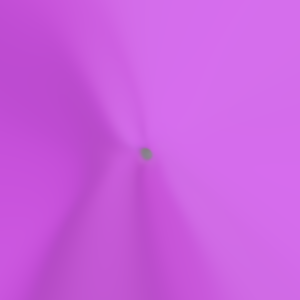
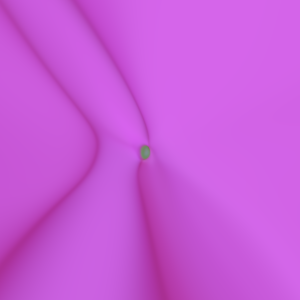
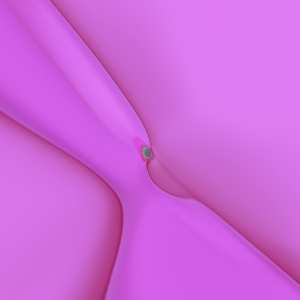
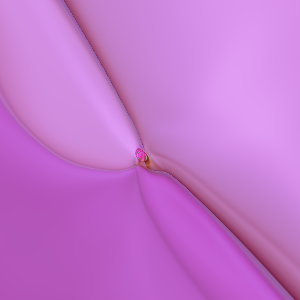

5:



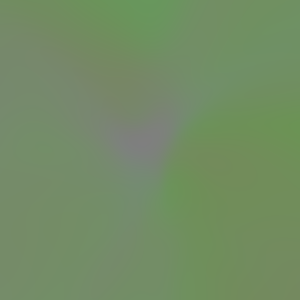
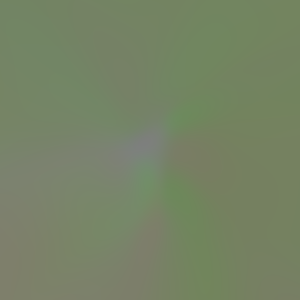
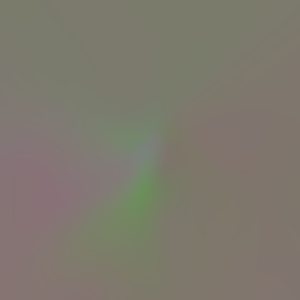
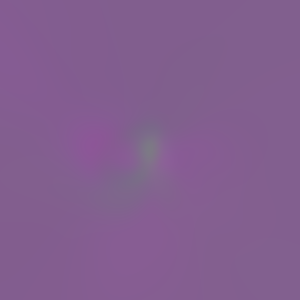
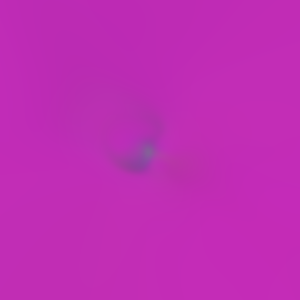
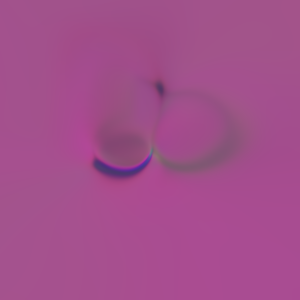
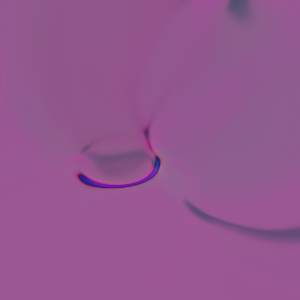
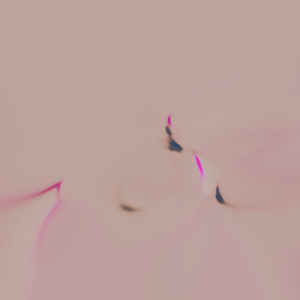

6:



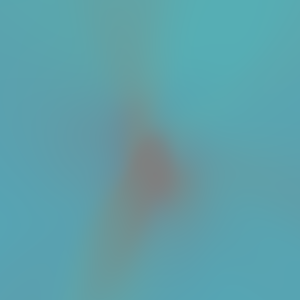
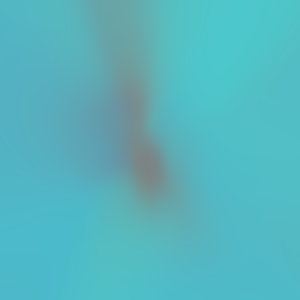
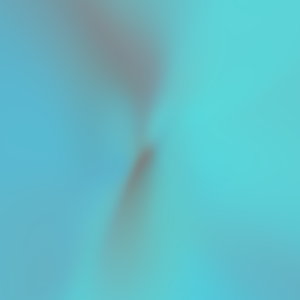
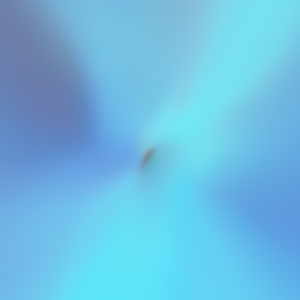
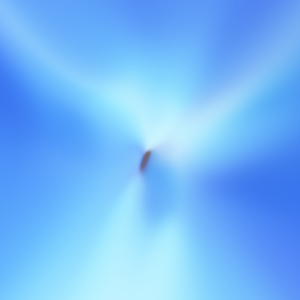
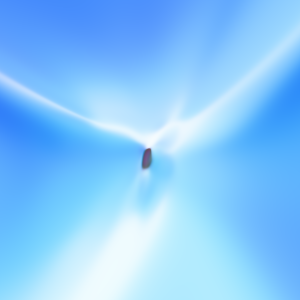
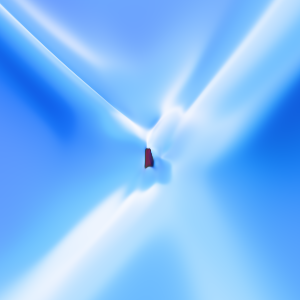
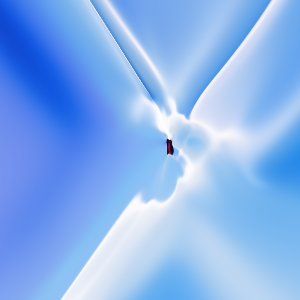

7:


In [ ]:
start_ind = 0
for j in range(30):
    print(str(j+start_ind)+ ':')
    for k in range(1):
        render_feature(cppn_f = lambda: image_cppn(300, 3, 20, 8, activation_fn=composite_activation), objective = objectives.channel("mixed4b_pool_reduce_pre_relu", j+start_ind))